## Gibbs Sampling with Blocks

In [ ]:
!conda install nbconvert[webpdf]

In [94]:
import os
import time
import glob
# import warnings
import itertools
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.special as scispe
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
# from numba import jit
# from numba.core.errors import (
#     NumbaWarning,
#     NumbaDeprecationWarning,
#     NumbaPendingDeprecationWarning
# )
from joblib import Parallel, delayed
# warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
# warnings.simplefilter("ignore", category=NumbaWarning)

### Draw from the Conditional Posterior of $(R^2, q)$

The conditional posterior of $(R^2, q)$ is given by:

\begin{equation*}
\pi(R^2, q | Y, U, X, \theta, z) \propto \\
\exp\left( -\dfrac{1}{2\sigma^2} \dfrac{k \bar{v}_x q (1-R^2)}{(R^2)} \beta^{\top} \text{diag}(z) \beta \right) \times \\
q^{s(z) + s(z)/2 + a - 1} (1 - q)^{k - s(z) + b - 1} \times (R^2)^{A - 1 - s(z)/2} (1 - R^2)^{s(z)/2 + B - 1},
\end{equation*}

where $s(z) = \sum_{i=1}^{k} z_i$. Discretize the support of $R^2$ and $q$ and sample from the discrete approximation.

In [10]:
# @jit(nopython=False)
def draw_r2_q(X, beta, sigma2, z, a, b, A, B, support_range_r2_q=None,
              return_posteriors=None, rng=None):
    """
    """
    k = len(beta)
    v_x = np.var(X, axis=0).mean()
    s_z = np.sum(z)

    # Define the ranges
    if support_range_r2_q:
        range_r2_q = support_range_r2_q
    else:
        EPSILON = 1e-5
        range_r2_q = np.concatenate([np.arange(0., 0.1, 0.001), 
                                     np.arange(0.11, 0.9, 0.01), 
                                     np.arange(0.901, 1.001, 0.001)])
        range_r2_q[0] += EPSILON
        range_r2_q[-1] -= EPSILON

    # Create a meshgrid
    R2, Q = np.meshgrid(range_r2_q, range_r2_q, indexing="ij", sparse=True)

    # Compute terms.
    beta_ = beta.reshape(beta.size, 1)
    expoterm = -0.5 / sigma2 * k * v_x * Q * (1 - R2)/R2 * (beta_.T * z @ beta_)
    pdf_q = Q ** (1.5 * s_z + a - 1) * (1 - Q) ** (k - s_z + b - 1)
    pdf_r2 = R2 ** (A - 0.5 * s_z - 1) * (1 - R2) ** (0.5 * s_z + B - 1)

    # Matrix of dimension `dim(support_q) x dim(support_r2)` 
    # with joint probabilities on (R2, q)
    posteriors = np.exp(expoterm) * pdf_r2 * pdf_q
    posteriors /= posteriors.sum()
    flat_posteriors = posteriors.flatten()

    if rng:
        index = rng.choice(flat_posteriors.size, p=flat_posteriors)
    else:
        index = np.random.choice(flat_posteriors.size, p=flat_posteriors)
    i, j = np.unravel_index(index, posteriors.shape)
    
    if return_posteriors:
        return (posteriors, None)  
    return range_r2_q[i], range_r2_q[j]

In [3]:
# # TEST
EPSILON = 1e-4
range_r2_q = np.concatenate([np.arange(0., 0.1, 0.001),
                             np.arange(0.11, 0.9, 0.01),
                             np.arange(0.901, 1.001, 0.001)])
range_r2_q[0] += EPSILON
range_r2_q[-1] -= EPSILON

np.random.seed(42)
T, k, l = 200, 100, 0
a, b, A, B = 1, 1, 1, 1
s, Ry, rho = 100, 0.5, 0.75
# U = np.random.rand(T, l)
X = np.random.multivariate_normal(np.zeros(k), 
                                  toeplitz(rho ** np.arange(k)), size=T)
betas = np.random.rand(k)
# phis = np.random.rand(l)
sigma2 = (1/Ry - 1) * np.mean((X @ betas)**2)
Y = X @ betas + np.random.multivariate_normal(np.full(T, 0), sigma2 * np.identity(T))
z = np.random.binomial(1, s/k, size=k)
gamma = 2

print(
f"""sigma2: {sigma2:.2f}
(s, Ry): {(s, Ry)}, s(z): {z.sum()}
dim(X): {X.shape}, dim(beta): {betas.shape}
""")
R2, q = draw_r2_q(X, betas, sigma2, z, a, b, A, B)
print("Drawn couple (R2, q)", R2, q)

sigma2: 189.29
(s, Ry): (100, 0.5), s(z): 100
dim(X): (200, 100), dim(beta): (100,)

Drawn couple (R2, q) 0.16999999999999998 0.9940000000000001


In [4]:
%%timeit
draw_r2_q(X, betas, sigma2, z, a, b, A, B) # 1e-6 s

1.34 ms ± 18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


$$
R^2  = \dfrac{q k \gamma^2 \bar{v}_{x}}{q k \gamma^2 \bar{v}_{x} + 1} \Rightarrow \gamma^2 = \dfrac{R^2}{q k \bar{v}_{x} (1 - R^2)}
$$

In [5]:
def compute_gamma2(R2, q, k, v_x):
    return R2 / (q*k*v_x*(1-R2))

v_x = np.var(X, axis=0).mean()
k = X.shape[1]
gamma = compute_gamma2(R2, q, k, v_x)
print("Gamma square", )

Gamma square


In [6]:
%%timeit
compute_gamma2(R2, q, k, v_x) # 1e-9 s

467 ns ± 9.18 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


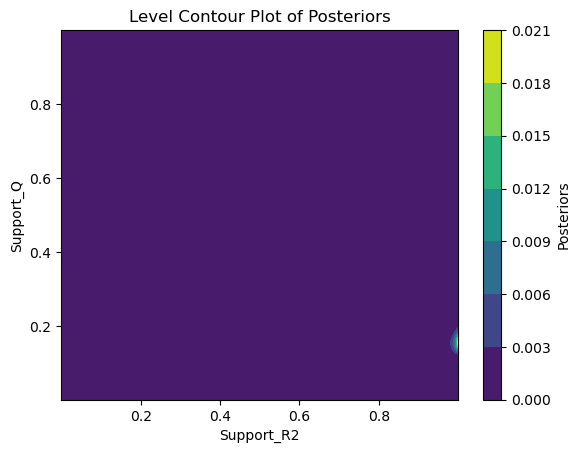

In [11]:
posteriors, _ = draw_r2_q(X, betas, sigma2, z, a, b, A, B, return_posteriors=True)
# Create a contour plot
plt.contourf(range_r2_q, range_r2_q, posteriors, cmap='viridis')
plt.xlabel('Support_R2')
plt.ylabel('Support_Q')
plt.title('Level Contour Plot of Posteriors')
plt.colorbar(label='Posteriors')
plt.show()

### Draw from the Conditional Posterior of $\phi$

The conditional posterior of $\phi$ is given by:

$$
\pi(\phi | Y, U, X, z, \beta, R^2, q, \sigma^2) = \pi(\phi | Y, U, X, \beta, \sigma^2) = \mathcal{N}((U'U)^{-1}U'(Y - X\beta), \sigma^2(U'U)^{-1}I).
$$



### Draw from the Conditional Posterior of $z$

The conditional posterior of $z$ is given by:

$$
\pi(z | Y, U, X, \phi, R^2, q) \propto q^{s(z)} (1 - q)^{k - s(z)} \left( \frac{1}{\gamma^2} \right)^{s(z) / 2} \left| W_e \right|^{-1/2} 
\left[ \dfrac{Y_e'Y_e - 2\beta_{eh}'W_e\beta_{eh}}{2} \right]^{-T/2} \Gamma\left( \frac{T}{2} \right),
$$

where 

* $\beta_{eh} := W_e^{-1}X_e'Y_e$, 

* $W_e := (X_e'X_e + I_{s(z)}/\gamma^2)$
  
* $Y_e := Y - U\phi$. 

Therefore, to sample from the posterior of $z|Y, U, X, ϕ, R2, q$  Draw iteratively from the distribution of $z_i | Y, U, X, \phi, R^2, q, z_{-i}$ using Gibbs sampling.



In [ ]:
assert (X.T.dot(X) == X.T @ X).all()
assert (X.T.dot(Y) == X.T @ Y).all()
assert np.power(np.linalg.det(X.T @ X), -0.5) == (np.linalg.det(X.T @ X)**(-0.5))

$$
\begin{align}
P_0 := P(z | z_i = 1) &\propto Q_{q, s(z), k, \gamma^2} \left| (W_1)_{s(z)} \right|^{-1/2} 
\left[ \dfrac{MSE_1}{2} \right]^{-T/2} \Gamma\left( \frac{T}{2} \right),
\\
P_1 := P(z | z_i = 0) &\propto Q_{q, (s(z) - 1), k, \gamma^2} \left| (W_0)_{s(z) - 1} \right|^{-1/2} 
\left[ \dfrac{MSE_0}{2} \right]^{-T/2} \Gamma\left( \frac{T}{2} \right),
\end{align}
$$

$$
\dfrac{P_1}{P_1 + P_0} = \dfrac{1}{1 + \frac{P_0}{P_1}} 
$$

In [13]:
# @jit(nopython=False)
def proba_z_i(Y, X, q, gamma_square, z, i):
    T = Y.shape[0]
    k = len(z)

    # Function to calculate W_e, beta_e_hat, det_W, and mse given z
    def calculate_statistics(z):
        s_z = np.sum(z)
        X_e = X[:, np.bool_(z)]
        I_sz = np.identity(s_z) if s_z > 0 else 1
        W_e = X_e.T @ X_e + I_sz / gamma_square
        beta_e_hat = np.linalg.inv(W_e) @ X_e.T @ Y
        det_W = np.linalg.det(W_e)
        mse = Y @ Y - beta_e_hat @ W_e @ beta_e_hat
        
        # print("s(z):", s_z)
        
        return W_e, beta_e_hat, det_W, mse

    # Pr(z_i=1)
    z[i] = 1
    W_e1, beta_e_hat1, det_W1, mse1 = calculate_statistics(z)

    # Pr(z_i=0)
    z[i] = 0
    W_e0, beta_e_hat0, det_W0, mse0 = calculate_statistics(z)
    
    z_proba = 1 / (1 + (det_W1 / det_W0)**0.5 * (mse1 / mse0)**T/2)
    
    return z_proba 

# TEST
proba_z = proba_z_i(Y, X, q, gamma, z, 1)
print("Proba zi", proba_z)

def draw_z_i(Y, X, q, gamma_square, z, i):
    zi_proba = proba_z_i(Y=Y, X=X, q=q, gamma_square=gamma_square, 
                         z=z, i=i)
    return 1 * (np.random.uniform() < zi_proba)

z_i = draw_z_i(Y, X, q, gamma, z, 1)
print(z_i)

Proba zi 0.15998400505435734
1


In [14]:
# @jit(nopython=False)
def gibbs_sampler_z(z_init, Y, X, q, gamma_square):
    z = z_init.copy()
            
    for i in range(z.shape[0]):
        # print(z)
        z[i] = draw_z_i(Y=Y, X=X, q=q, gamma_square=gamma_square, 
                        z=z, i=i)
    return z

# Example usage
np.random.seed(42)
z = gibbs_sampler_z(z, Y, X, q, gamma)
print(z)

[0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1]


In [15]:
%%timeit
gibbs_sampler_z(z, Y, X, q, gamma) # 1e-8

42.2 ms ± 3.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Draw from the Conditional Posterior of $\sigma^2$

The conditional posterior of $\sigma^2$ is given by:

$$
\pi(\sigma^2 | Y, U, X, \phi, R^2, q, z) = I_{\Gamma}\left( \frac{T}{2}, Y_e'Y_e - \beta_{\text{be}}'(X_e'X_e + I_{s(z)}/\gamma^2)\beta_{\text{be}} \right).
$$


In [17]:
# @jit(nopython=False)
def compute_active_components(Y, X, z, s_z, gamma_square):
    X_tilde = X[:, np.bool_(z)] if s_z > 0 else np.zeros(T).reshape(T, 1)
    I_sz = np.identity(s_z) if s_z > 0 else np.identity(1)
    W_tilde = X_tilde.T @ X_tilde + I_sz / gamma_square
    W_tilde_inv = np.linalg.inv(W_tilde)
    beta_tilde_hat =  W_tilde_inv @ X_tilde.T @ Y
    mse = Y @ Y - beta_tilde_hat @ W_tilde @ beta_tilde_hat

    return X_tilde, W_tilde_inv, mse

# TEST
s_z = np.sum(z)
X_tilde, W_tilde_inv, mse = compute_active_components(Y, X, z, s_z, gamma)


# @jit(nopython=False)
def draw_sigma2(T, mse):
    # Draw from the posterior
    sigma2 = stats.invgamma(T/2, scale=mse/2).rvs(size=1)[0]
    return sigma2

print(draw_sigma2(T, mse))

313.0540683429524


### Draw from the Conditional Posterior of $\beta_e := \tilde{\beta}$

The conditional posterior of $\beta_e$ is given by:

$$
\begin{align}
\pi(\beta_e | Y, U, X, \phi, R^2, q, \sigma^2, z) &= \mathcal{N}\left( (I_{s(z)}/\gamma^2 + X_e'X_e)^{-1}X_e'(Y - U\phi), \sigma^2 (I_{s(z)}/\gamma^2 + X_e'X_e)^{-1} \right) \\ 
&= \mathcal{N}\left( W_e^{-1}X_e'(Y - U\phi), \sigma^2 W_e^{-1} \right)
\end{align}
$$

In [18]:
np.random.seed(42)
def draw_beta_active(
    Y: np.ndarray, 
    X_tilde: np.ndarray, 
    W_tilde_inv: np.ndarray, 
    sigma2: float, 
    s_z: int, 
    verbose: bool=False
) -> np.ndarray:
    """Draw the active beta coefficients.

    Args:
        Y (np.ndarray): _description_
        X_tilde (np.ndarray): _description_
        W_tilde_inv (np.ndarray): _description_
        sigma2 (float): _description_
        s_z (int): _description_
        verbose (bool): _description_

    Returns:
        np.ndarray: _description_
    """
    mean = np.array(W_tilde_inv @ X_tilde.T @ Y)
    cov = np.array(sigma2 * W_tilde_inv)
    if verbose:
        print(f"X_e:{X_tilde[:1]}, mean:{mean[:1]}, cov:{cov[:1]}")
    # Draw from the posterior
    beta_active = np.random.multivariate_normal(mean, cov, size=s_z)[0]

    return beta_active

print("Function 2\n", draw_beta_active(Y, X_tilde, W_tilde_inv, sigma2, s_z))

Function 2
 [ 0.20405275 -0.12669905  0.18232883  1.21896013  1.38118405  1.06019268
  0.8397868   1.1676977   0.57410144  1.15912837  1.09374431  0.94232727
  0.79630556  0.44090027  1.42228157  0.50819847  1.814412    1.30510681
  0.173074    1.43618413  1.76651716]


#### Generate the design matrix $X = (X_1,..., X_T), X_t = (X_{t1}, \dots, X_{tk}) \sim \mathcal{N}(\mu, \Sigma)$

$ \mu = \mathbb{0}_k, \Sigma = (\rho^{|i-j|})_{1 \leq i,j \leq k }$

In [19]:
def generate_X(T: int, k: int, rho: float) -> np.ndarray:
    """Generate a features matrix from a zero-mean Normal distribution with 
    a Toeplitz correlation with $corr(x_{t, i} - x_{t, j}) = \rho^{|i - j|}$.

    Args:
        T (int): number of observations.
        k (int): number of features.
        rho (float): base Toeplitz matrix correlation parameter.

    Returns:
        X (np.ndarray): features matrix.
    """
    # Create a matrix of difference i - j for all (i, j) in range(k) x range(k).
    diff = np.arange(k)[:, None] - np.arange(k)[None, :]

    # Compute a Toeplitz correlation matrix and define the mean vector.
    cov_matrix = rho ** np.abs(diff)
    mean = np.zeros(k)
    
    # Generate predictors X with Toeplitz correlation matrix.
    X = np.random.multivariate_normal(mean, cov=cov_matrix, size=T)
    X /= np.std(X, axis=0)

    return X

# Test generate_X.
X = generate_X(T=200, k=100, rho=0.75)
print(X.shape)

(200, 100)


#### Draw $\tilde{\beta} = (\tilde{\beta}_1, \dots, \tilde{\beta}_s), \tilde{\beta}_i \overset{\tiny i.i.d.}{\sim} \mathcal{N}(0, 1) $

$S = (i_1,...,i_s) \sim RandomChoice(from=(1,...,k)), s \leq k$

$\beta_{j} = \tilde{\beta}_{j} \mathbb{I}{[j \in \{S\}]} $

In [20]:
def draw_regression_coefficients(k: int, s: int) -> np.ndarray:
    """
    Draw regression coefficients beta.

    Parameters:
        k (int): Total number of coefficients.
        s (int): Number of active coefficients.

    Returns:
        numpy.ndarray: Array of regression coefficients with 's' active indices.
    """
    beta = np.zeros(k)
    active_indices = np.random.choice(k, size=s, replace=False)
    beta[active_indices] = np.random.standard_normal(size=s)
    return beta


# TEST
s = int(k/2)
beta = draw_regression_coefficients(k, s)
print(f"Regression coefficient for {k, s}:", beta.shape, beta[:5])

Regression coefficient for (100, 50): (100,) [-0.65528153  2.00850573 -0.598901    0.08081318 -0.36812749]


#### Simulate latent variable $z = (z_1,...,z_k), z_i \overset{\tiny i.i.d}{\sim} \mathcal{B}(s/k)$

In [21]:
def simulate_latent_variable(k: int, s: int) -> np.ndarray:
    """
    Simulate latent variable z.

    Parameters:
        k (int): Total number of latent variables.
        s (int): Number of active latent variables.

    Returns:
        numpy.ndarray: Array representing the simulated latent variable z.
    """
    z = np.random.binomial(1, p=s/k, size=k)
    return z

# TEST
z = simulate_latent_variable(k, s)
print("Latent variable", z.shape, z[:20])

Latent variable (100,) [1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0]


#### Draw error terms $\varepsilon \sim \mathcal{N}(0, \sigma^2 I_{T})$, $\sigma^2 = (1/Ry - 1) \sum_{t=1}^{T} (\beta'x_t)^2 / T$

In [22]:
def draw_error_terms(beta: np.ndarray, X: np.ndarray, T: int, Ry: float) -> np.ndarray:
    """
    Draw error terms epsilon.

    Parameters:
        beta (numpy.ndarray): Regression coefficients.
        X (numpy.ndarray): Design matrix.
        T (int): Number of observations.
        Ry (float): Variance of Y.

    Returns:
        numpy.ndarray: Array of error terms epsilon.
    """
    sigma2 = (1/Ry - 1) * np.sum((X @ beta)**2) / T
    cov_matrix = np.eye(T) * sigma2
    epsilon = np.random.multivariate_normal(mean=np.zeros(T), cov=cov_matrix, size=T)[0]
    return epsilon, sigma2

# TEST
Ry = 0.5
epsilon, sigma2 = draw_error_terms(beta, X, T, Ry)
print(f"Draw error terms. Epsilon {epsilon.shape}:{epsilon[:2]}. SigmaSquare {sigma2}")

Draw error terms. Epsilon (200,):[-5.1771873  -0.73475585]. SigmaSquare 34.978682660500766


#### Compute response variable $Y = X \beta + \varepsilon$

In [23]:
def compute_response_variable(X: np.ndarray, beta: np.ndarray, epsilon: np.ndarray) -> np.ndarray:
    """
    Compute response variable Y.

    Parameters:
        X (numpy.ndarray): Design matrix of shape (T, k).
        beta (numpy.ndarray): Regression coefficients of shape (k,).
        epsilon (numpy.ndarray): Error terms of shape (T,).

    Returns:
        numpy.ndarray: Response variable Y of shape (T,).
    """
    Y = X @ beta + epsilon
    return Y

# TEST 
Y = compute_response_variable(X, beta, epsilon)
print("Response variable", Y.shape, Y[:2])

Response variable (200,) [-7.85306678  3.615662  ]


#### Simulate data. $(Y, X, \beta, z, \sigma^2) = f(s, R_y, T, k, \rho)$

In [24]:
def simulate_data(s: int, Ry: float, T: int = 200, k: int = 100, rho: float = 0.75
                  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate data for a regression model.

    Parameters:
        s (int): Number of active features.
        Ry (float): Percentage of explained variance.
        T (int): Number of observations (default is 200).
        k (int): Number of features (default is 100).
        rho (float): Autoregressive parameter for feature generation 
            (default is 0.75).

    Returns:
        Y (np.ndarray): Response variable.
        X (np.ndarray): Feature matrix.
        beta (np.ndarray): Regression coefficients.
        z (np.ndarray): Simulated latent variable (index of selected features).
    """
    # Generate features X.
    X = generate_X(T, k, rho)

    # Draw regression coefficients beta.
    beta = draw_regression_coefficients(k, s)

    # Simulate latent variable z.
    z = simulate_latent_variable(k, s)

    # Draw error terms epsilon.
    epsilon, sigma2 = draw_error_terms(beta, X, T, Ry)

    # Compute response variable Y.
    Y = compute_response_variable(X, beta, epsilon)

    return Y, X, beta, z, sigma2

# TEST
Y, X, beta, z, sigma2 = simulate_data(s=100, Ry=0.50)
print(Y.shape, X.shape, z.shape)
print(Y[:2], X[0, :2], z[:2], sigma2, beta.shape)

(200,) (200, 100) (100,)
[ -2.9332894  -34.63914417] [-0.96119213 -0.97835381] [1 1] 172.8063784860829 (100,)


In [25]:
import csv


def save_medians(q_medians, s, Ry, dataset_index, save_to="."):
    if "." not in save_to:
        os.makedirs(save_to, exist_ok=True)
        
    # Save q_medians to CSV
    with open(f"{save_to}/result_medians_s_{s}_Ry_{Ry}_dataset{dataset_index}.csv", 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Key', 'Value'])
        csvwriter.writerows(q_medians.items())


def save_samples(q_sample, s, Ry, dataset_index, save_to="."):
    if "." not in save_to:
         os.makedirs(save_to, exist_ok=True)
    # Save q_sample to CSV
    with open(f"{save_to}/result_sample_s_{s}_Ry_{Ry}_dataset{dataset_index}.csv", 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Key', 'Value'])
        csvwriter.writerows(q_sample.items())


def save_results2(q_medians_list, q_sample_list, save_to="."):
    if "." not in save_to:
        os.makedirs(save_to, exist_ok=True)
    # Save q_medians to CSV
    with open(f"{save_to}/result_medians.csv", 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Key', 'Value'])
        csvwriter.writerows(q_medians_list.items())

    # Save q_sample to CSV
    with open(f"{save_to}/result_samples.csv", 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Key', 'Value'])
        csvwriter.writerows(q_sample_list.items())

### Final Gibbs Sampling Procedure

In [40]:
def gibbs_sampling_parallel(
    s_range: List[int] = [5, 10, 100],
    Ry_range: List[float] = [0.02, 0.25, 0.50],
    T: int = 200,
    k: int = 100,
    rho: float = 0.75,
    a: float = 1,
    b: float = 1,
    A: float = 1,
    B: float = 1,
    n_datasets: int = 100,
    n_iter: int = 5_000,
    burn_in: int = 1_000,
    save_to: str = ".",
    n_jobs: int = -1
):
    """
    Perform parallelized Gibbs sampling for updating model parameters.

    This function applies Gibbs sampling to update the selection probability (q)
    of features in a statistical model based on the initial number of active features (s)
    and the proportion of explained variance (Ry). It processes multiple pairs of (s, Ry)
    in parallel for a given number of datasets, iterations, and burn-in period.

    Args:
        s_range (List[int], optional): Range for the number of active features.
            Defaults to [5, 10, 100].
        Ry_range (List[float], optional): Range for the proportion of explained
            variance. Defaults to [0.02, 0.25, 0.50].
        T (int, optional): Number of observations. Defaults to 200.
        k (int, optional): Number of features. Defaults to 100.
        rho (float, optional): Correlation coefficient. Defaults to 0.75.
        a, b (float, optional): Beta parameters for the prior of 'q'.
            Defaults to 1, 1.
        A, B (float, optional): Beta parameters for the prior of 'R2'.
            Defaults to 1, 1.
        n_datasets (int, optional): Number of datasets. Defaults to 100.
        n_iter (int, optional): Number of iterations. Defaults to 5_000.
        burn_in (int, optional): Burn-in period. Defaults to 1_000.
        save_to (str, optional): Directory to save results. Defaults to ".".
        n_jobs (int, optional): Number of parallel jobs. Set to -1 to use all available cores.

    Returns:
        Tuple[Dict[str, float], Dict[str, List[float]]]: Median of q for each dataset, and q samples
        for one dataset, for each parameter pair (s, Ry).
    """

    q_medians_list = {}  # Dictionary to store medians
    q_sample_list = {}   # Dictionary to store samples

    def process_pair(s, Ry):
        """
        Process a pair of (s, Ry) in parallel for multiple datasets.

        Args:
            s (int): Number of active features.
            Ry (float): Proportion of explained variance.

        Returns:
            Tuple[Dict[str, float], Dict[str, List[float]]]: Local medians and samples.
        """
        print(f"(s, Ry) = {s, Ry}")
        start_time = time.time()

        local_q_medians = {}  # Local dictionary to store medians
        local_q_samples = {}  # Local dictionary to store samples

        for i in range(n_datasets):
            Y, X, beta, z, sigma2 = simulate_data(s=s, Ry=Ry, T=T, k=k, rho=rho)
            active_index_beta = np.argwhere(beta == 0)
            v_x = np.var(X, axis=0).mean()
            q_list = []  # Reset q list

            for j in range(n_iter):
                R2, q = draw_r2_q(X, beta, sigma2, z, a, b, A, B)
                gamma2 = compute_gamma2(R2, q, k, v_x)
                z = gibbs_sampler_z(z, Y, X, q, gamma2)
                s_z = np.sum(z)

                X_tilde, W_tilde_inv, mse = compute_active_components(Y, X, z, s_z, gamma2)
                sigma2 = draw_sigma2(T, mse)

                if s_z == 0:
                    beta = np.zeros(beta.shape[0])
                else:
                    beta_tilde = draw_beta_active(Y, X_tilde, W_tilde_inv, sigma2, s_z)
                    beta = np.zeros(k)
                    beta[np.bool_(z)] = beta_tilde

                q_list.append(q)
                if j == n_iter - 1:
                    local_q_medians[f"{s}:{Ry}:{i}"] = np.median(q_list[burn_in:])
            
            if i == n_datasets - 1:
                local_q_samples[f"{s}:{Ry}:{i}:{j}"] = q_list[burn_in:]
                save_samples(local_q_samples, s, Ry, i, save_to=save_to)
                save_medians(local_q_medians, s, Ry, i, save_to=save_to)
                
            print(f"Dataset no. {i}. Elapsed Time {time.time() - start_time}")

        return local_q_medians, local_q_samples

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_pair)(s, Ry) for s, Ry in itertools.product(s_range, Ry_range)
    )

    # Combine results from different processes
    for local_q_medians, local_q_samples in results:
        q_medians_list.update(local_q_medians)
        q_sample_list.update(local_q_samples)

    return q_medians_list, q_sample_list

In [41]:
%timeit
gibbs_sampling_parallel(s_range=[5], Ry_range=[0.10, 0.5], T=200, k=100, rho=0.75, n_datasets=5, n_iter=20, burn_in=5, save_to="tests") # 6 s / per pairs (s, Ry) for 10 * 50 = 500 iterations

({'5:0.1:0': 0.12,
  '5:0.1:1': 0.13,
  '5:0.1:2': 0.13999999999999999,
  '5:0.1:3': 0.2899999999999999,
  '5:0.1:4': 0.12,
  '5:0.5:0': 0.3199999999999999,
  '5:0.5:1': 0.3099999999999999,
  '5:0.5:2': 0.2899999999999999,
  '5:0.5:3': 0.3199999999999999,
  '5:0.5:4': 0.3599999999999999},
 {'5:0.1:4:19': [0.19999999999999996,
   0.088,
   0.18999999999999995,
   0.11,
   0.08600000000000001,
   0.097,
   0.097,
   0.12,
   0.17999999999999997,
   0.18999999999999995,
   0.12,
   0.17999999999999997,
   0.22999999999999993,
   0.084,
   0.14999999999999997],
  '5:0.5:4:19': [0.4099999999999998,
   0.4599999999999998,
   0.4699999999999998,
   0.19999999999999996,
   0.3599999999999999,
   0.33999999999999986,
   0.3199999999999999,
   0.37999999999999984,
   0.3099999999999999,
   0.39999999999999986,
   0.4099999999999998,
   0.39999999999999986,
   0.34999999999999987,
   0.2999999999999999,
   0.2899999999999999]})

In [42]:
q_medians_list, q_sample_list = gibbs_sampling_parallel(save_to="results")

/opt/mamba/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/tmp/ipykernel_10353/2789302364.py:28: RuntimeWarning: invalid value encountered in scalar divide


(s, Ry) = (5, 0.1)
Dataset no. 0. Elapsed Time 0.399066686630249
Dataset no. 1. Elapsed Time 0.8171193599700928
Dataset no. 2. Elapsed Time 1.199298620223999
Dataset no. 3. Elapsed Time 1.7630727291107178
Dataset no. 4. Elapsed Time 2.154756546020508
(s, Ry) = (5, 0.5)
Dataset no. 0. Elapsed Time 0.5978009700775146
Dataset no. 1. Elapsed Time 1.2188584804534912
Dataset no. 2. Elapsed Time 1.850752830505371
Dataset no. 3. Elapsed Time 2.366569995880127
Dataset no. 4. Elapsed Time 2.9196319580078125
(s, Ry) = (100, 0.02)
Dataset no. 0. Elapsed Time 67.15527057647705
Dataset no. 1. Elapsed Time 138.87161660194397
Dataset no. 2. Elapsed Time 208.7194538116455
Dataset no. 3. Elapsed Time 283.54841327667236
Dataset no. 4. Elapsed Time 361.6622712612152
Dataset no. 5. Elapsed Time 433.56809091567993
Dataset no. 6. Elapsed Time 494.7204432487488
Dataset no. 7. Elapsed Time 554.567015171051
Dataset no. 8. Elapsed Time 622.5130572319031
Dataset no. 9. Elapsed Time 701.3709290027618
Dataset no. 1

In [43]:
save_results2(q_medians_list, q_sample_list)

In [54]:
q_medians_, q_samples_ = pd.read_csv("result_medians.csv"), pd.read_csv("result_samples.csv")

In [59]:
q_medians, q_samples = np.array(pd.eval(q_medians_["Value"])[:-1]), np.array(pd.eval(q_samples_["Value"]))

In [61]:
print(q_samples.shape)
print(q_medians.shape)

(9, 4000)
(100,)


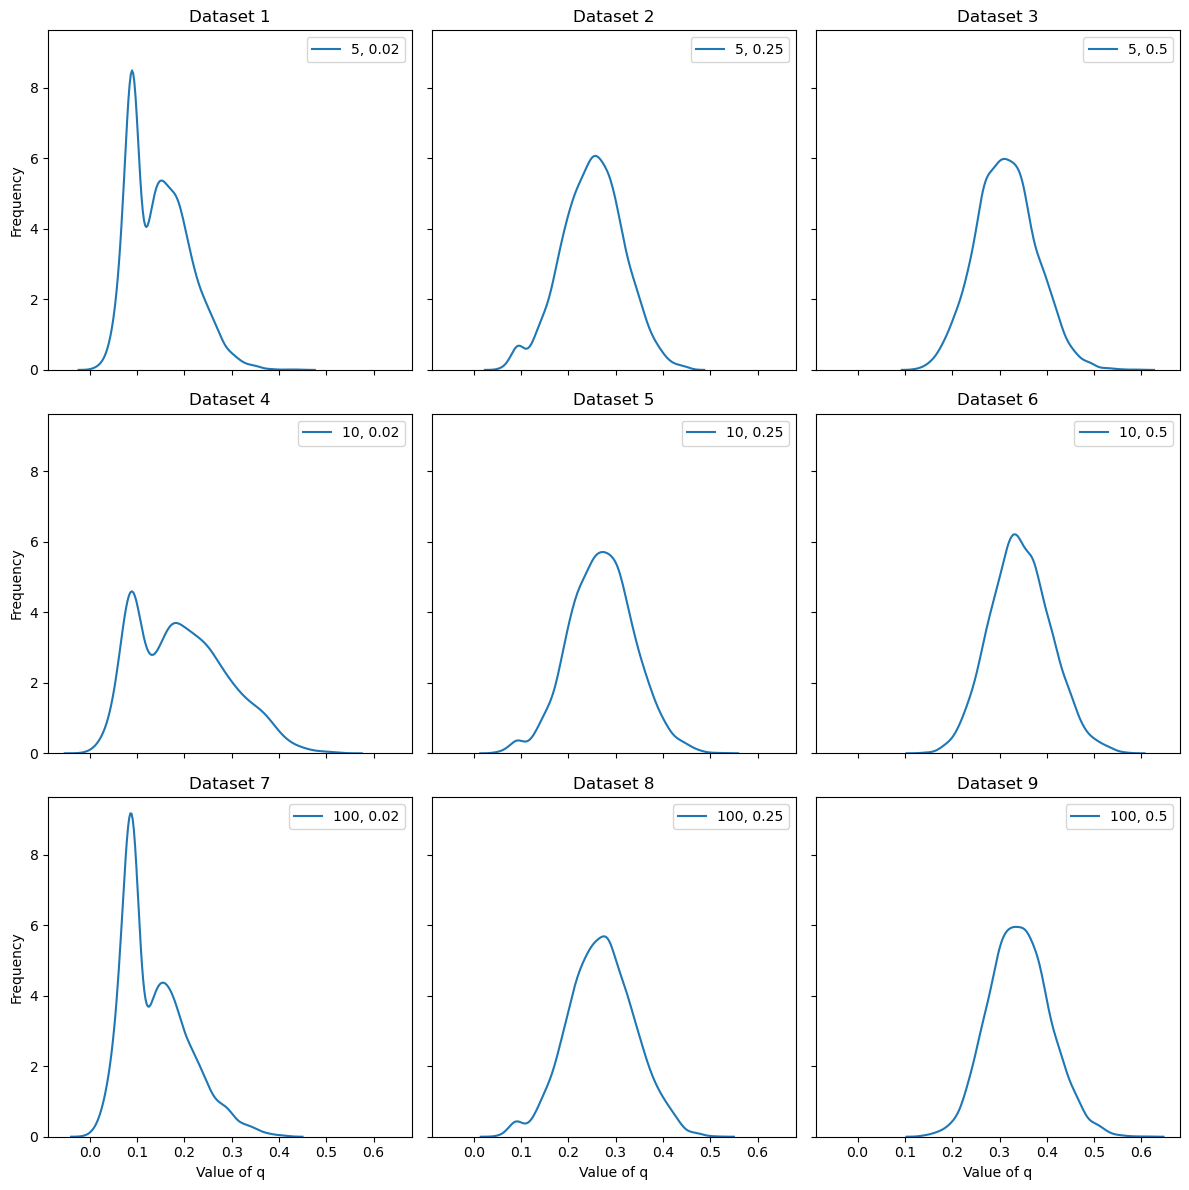

In [112]:
# Labels (s, Ry)
# labels = itertools.product([5, 10, 100], [0.02, 0.25, 0.5])
labels = [(s, Ry) for s in [5, 10, 100] for Ry in [0.02, 0.25, 0.5]]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over datasets and corresponding labels
for i in range(len(labels)):
    # Select the dataset
    dataset = q_samples[i, :]
    
    # Get the corresponding label
    label = labels[i]
    
    # Create a histogram for the dataset on the current subplot
    # sns.histplot(dataset, ax=axes[i], bins=50, alpha=0.7, label=f"{label[0]}, {label[1]}")
    sns.kdeplot(dataset, ax=axes[i], label=f"{label[0]}, {label[1]}", common_norm=False)

    # Find the mode (most frequent value) of the dataset
    # mode_value = stats.mode(dataset)[0].round(2)
    # Plot a vertical line at the mode
    # axes[i].axvline(mode_value, color='red', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value}')
    
    
    # Set subplot title
    axes[i].set_title(f"Dataset {i + 1}")

    # axes[i].

    # Add a legend
    axes[i].legend()
    
    # Set x-axis label for the bottom row
    if i >= 6:
        axes[i].set_xlabel("Value of q")
    
    # Set y-axis label for the leftmost column
    if i % 3 == 0:
        axes[i].set_ylabel("Frequency")


# Adjust layout for better readability
plt.tight_layout()

plt.savefig("images/q_samples.png")
# Show the plot
plt.show()


In [98]:
# Specify the folder path containing the CSV files
folder_path = "results"

# Initialize an empty dictionary to store the data
data_dict = {}

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.startswith("result_medians_s_") and filename.endswith(".csv"):
        # Extract s and Ry values from the filename
        s_value = filename.split("_")[3]
        Ry_value = filename.split("_")[5]

        # Generate the key based on s and Ry values
        key = f"s_{s_value}_Ry_{Ry_value}"

        # Read the CSV file and extract the 'Value' column
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        values = df['Value'].tolist()

        # Add the data to the dictionary
        data_dict[key] = values

# Now, data_dict contains the data from all CSV files


In [105]:
q_medians = np.array(list(data_dict.values()))

In [107]:
q_medians.shape

(9, 100)

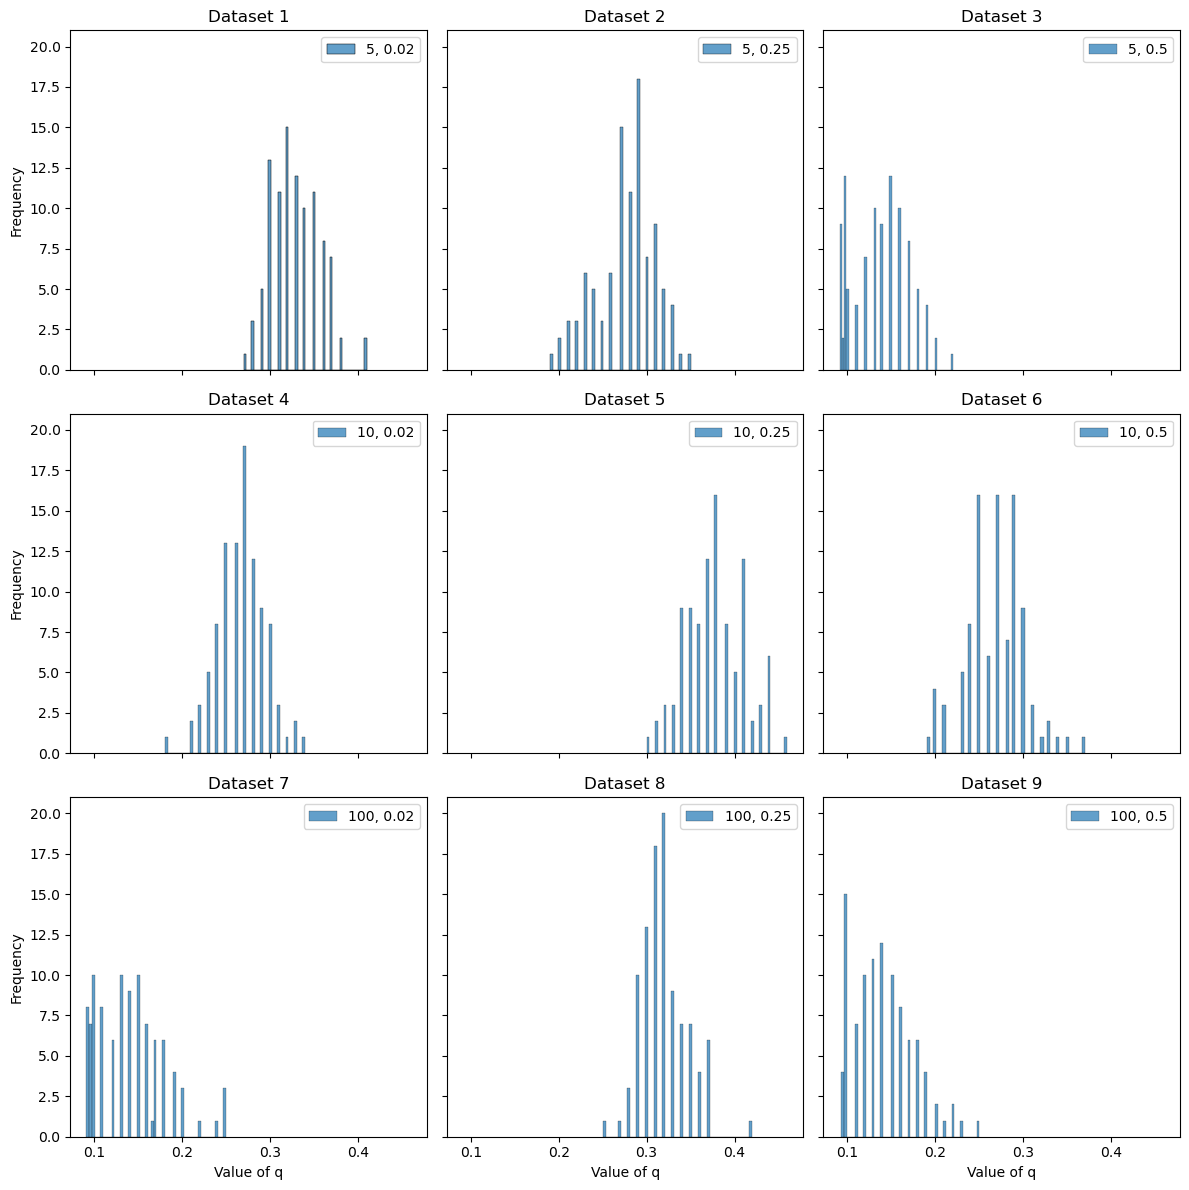

In [113]:
# Labels (s, Ry)
# labels = itertools.product([5, 10, 100], [0.02, 0.25, 0.5])
labels = [(s, Ry) for s in [5, 10, 100] for Ry in [0.02, 0.25, 0.5]]

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over datasets and corresponding labels
for i in range(len(labels)):
    # Select the dataset
    dataset = q_medians[i, :]
    
    # Get the corresponding label
    label = labels[i]
    
    # Create a histogram for the dataset on the current subplot
    sns.histplot(dataset, ax=axes[i], bins=50, alpha=0.7, label=f"{label[0]}, {label[1]}")
    # sns.kdeplot(dataset, ax=axes[i], label=f"{label[0]}, {label[1]}", common_norm=False)

    # Find the mode (most frequent value) of the dataset
    # mode_value = stats.mode(dataset)[0].round(2)
    # Plot a vertical line at the mode
    # axes[i].axvline(mode_value, color='red', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value}')
    
    # Set subplot title
    axes[i].set_title(f"Dataset {i + 1}")

    # axes[i].

    # Add a legend
    axes[i].legend()
    
    # Set x-axis label for the bottom row
    if i >= 6:
        axes[i].set_xlabel("Value of q")
    
    # Set y-axis label for the leftmost column
    if i % 3 == 0:
        axes[i].set_ylabel("Frequency")


# Adjust layout for better readability
plt.tight_layout()

plt.savefig("images/q_medians.png")
# Show the plot
plt.show()
